In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [51]:
df = pd.read_csv('../data/unprocessed/unprocessed.csv')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3164 entries, 0 to 3163
Data columns (total 12 columns):
Unnamed: 0     3140 non-null float64
PP             3164 non-null object
C              3164 non-null object
timestamp      3164 non-null object
HR             1514 non-null object
RMSSD          1514 non-null object
SCL            2602 non-null object
date           3164 non-null object
subject        3164 non-null object
label          3164 non-null object
Condition      3164 non-null object
ElapsedTime    3164 non-null object
dtypes: float64(1), object(11)
memory usage: 296.8+ KB


In [53]:
# Labels: 'rest', 'no stress', 'time pressure', 'interruption'

In [54]:
df.describe()

,Unnamed: 0
count,3140.000000
mean,1569.500000
std,906.584249
min,0.000000
25%,784.750000
50%,1569.500000
75%,2354.250000
max,3139.000000


In [55]:
df.head()

,Unnamed: 0,PP,C,timestamp,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,0.0,PP1,1,20120918T131600000,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,1.0,PP1,1,20120918T131700000,61,0.06142,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,2.0,PP1,1,20120918T131800000,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,3.0,PP1,1,20120918T131900000,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,4.0,PP1,1,20120918T132000000,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


In [56]:
df.drop(columns=["Unnamed: 0", 'PP', 'C', 'timestamp'], inplace=True)

In [57]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,61,0.06142,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


In [58]:
break_idxs = []
for idx, d in enumerate(df['date']):
    try:
        pd.to_datetime(d)
    except:
        print("PROBLEM")
        print(idx)
        print('----')
        break_idxs.append(idx)

PROBLEM
129
----
PROBLEM
251
----
PROBLEM
380
----
PROBLEM
509
----
PROBLEM
635
----
PROBLEM
762
----
PROBLEM
893
----
PROBLEM
1010
----
PROBLEM
1133
----
PROBLEM
1262
----
PROBLEM
1390
----
PROBLEM
1520
----
PROBLEM
1647
----
PROBLEM
1777
----
PROBLEM
1899
----
PROBLEM
2029
----
PROBLEM
2159
----
PROBLEM
2279
----
PROBLEM
2410
----
PROBLEM
2540
----
PROBLEM
2647
----
PROBLEM
2774
----
PROBLEM
2904
----
PROBLEM
3035
----


In [59]:
df.loc[3035]

HR                      HR
RMSSD                RMSSD
SCL                    SCL
date                  date
subject            subject
label                label
Condition        Condition
ElapsedTime    ElapsedTime
Name: 3035, dtype: object

In [60]:
df = df.drop(break_idxs)

In [61]:
df['date'] = pd.to_datetime(df['date'])

In [62]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,61,0.06142,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3163
Data columns (total 8 columns):
HR             1490 non-null object
RMSSD          1490 non-null object
SCL            2578 non-null object
date           3140 non-null datetime64[ns]
subject        3140 non-null object
label          3140 non-null object
Condition      3140 non-null object
ElapsedTime    3140 non-null object
dtypes: datetime64[ns](1), object(7)
memory usage: 220.8+ KB


In [78]:
df = df.set_index(df['date'])

In [79]:
df['HR'] = df['HR'].astype('int64')
df['RMSSD'] = df['RMSSD'].astype('float64')

In [80]:
# RR is the peak in a heartbeat
# RR interval (RRI) is the distance between peaks in milliseconds between beats from an ECG
# RMSDD is the square root of the mean distance between RR for a period of time
# RMSDD is used as HRV calculation based on one minute intervals
# SDNN is the standard deviaiton of all the RR intervals

In [81]:
178 / 60

2.966666666666667

In [82]:
# 2.97 hours of data per participant

In [83]:
# Conditions are R: rest, N: no stress, T: time pressure, I: interruption 
# No stress - Allowed to work for a maximum 45 minutes but they don't know the duration 
# Time Pressure - Time limit of 2/3 to complete task based on duration in no stress
# Interruption - Received 8 emails in the middle of the assigned task 
# Relax - Not working on a task

In [84]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
date,,,,,,,,
2012-09-18 13:17:00,61,0.061420,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2012-09-18 13:18:00,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
2012-09-18 13:19:00,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
2012-09-18 13:20:00,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4
2012-09-18 13:21:00,65,0.037098,76.873877,2012-09-18 13:21:00,p1,rest,R,5


In [85]:
subjects = df['subject'].unique()

In [86]:
subjects = subjects[(subjects != ['p8'])]
subjects = subjects[(subjects != ['p11'])]
subjects = subjects[(subjects != ['p15'])]

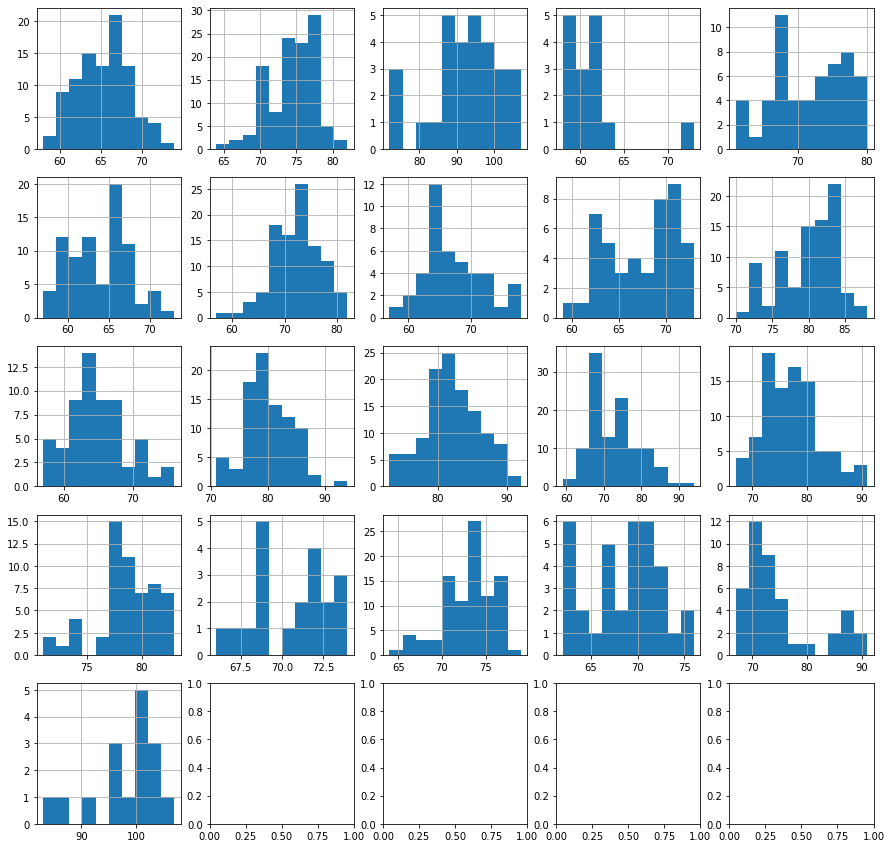

In [87]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for ax, subject in zip(axs.flatten(), subjects):
    df[df['subject'] == (subject)]['HR'].hist(ax=ax)

In [88]:
df.head()

,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
date,,,,,,,,
2012-09-18 13:17:00,61,0.061420,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2012-09-18 13:18:00,64,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
2012-09-18 13:19:00,60,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
2012-09-18 13:20:00,61,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4
2012-09-18 13:21:00,65,0.037098,76.873877,2012-09-18 13:21:00,p1,rest,R,5


In [89]:
df = df.dropna()

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1437 entries, 2012-09-18 13:17:00 to 2012-11-07 14:39:00
Data columns (total 8 columns):
HR             1437 non-null int64
RMSSD          1437 non-null float64
SCL            1437 non-null object
date           1437 non-null datetime64[ns]
subject        1437 non-null object
label          1437 non-null object
Condition      1437 non-null object
ElapsedTime    1437 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 101.0+ KB


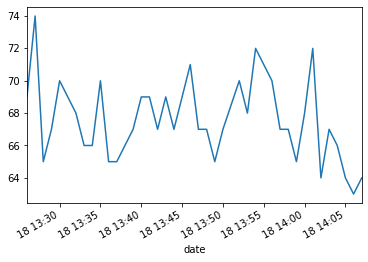

In [93]:
df[(df['subject'] == 'p1') & (df['label'] == 'no stress')]['HR'].plot()

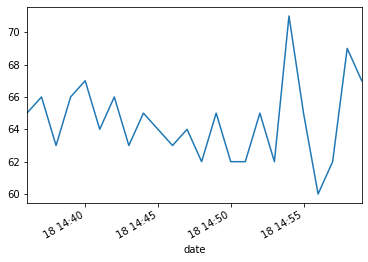

In [94]:
df[(df['subject'] == 'p1') & (df['label'] == 'time pressure')]['HR'].plot()

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 10))
# for i in subjects:
#     try:
#         new_df[(new_df['subject'] == i) & (new_df['label'] == 'no stress')]['HR'].plot(ax=ax, label=i)
#     except:
#         print(i)
#         continue
#     ax.legend()